## Optimal Control for nuclear spin polarization in Nitrogen-vacany center and $^{13}\text{C}$-nuclear spins system

Spin-qubit polarization is a useful tool for NMR, solid state spin systems, quantum sensing and for quantum information applications [1]. This notebook is a simple example of using the QuOCS package to find optimal control solutions for the Nitrogen-vacancy (NV) spin to polarize a specific $^{13}\text{C}$-nuclear spin in the diamond lattice. In the presence of an external bias magnetic field $\vec{B}$, the Hamiltonian for such NV and $n$ $^{13}\text{C}$ spins system can be described as:

\begin{equation}\hat{H} =\overbrace{\hbar D\left[\hat{S}_Z^2-\frac{2}{3}\right]}^\text{NV zero field term} + \overbrace{\hbar\gamma_{nv}\vec{B}\cdot{\vec{S}}}^\text{NV Zeeman interaction}\nonumber+\hbar{{\sum}}_{i=1}^{n}\left(\overbrace{{\vec{S}}\mathcal{A}_i{\vec{I}}_i}^\text{coupling interactions}+\overbrace{\gamma_i\vec{B}\cdot{\vec{I}}_i}^\text{nuclear Zeeman interactions}\right),
\end{equation}

where $D$=2.87 GHz is the NV zero field parameter, $\hbar$ is the reduced Plank's constant, $\gamma_{nv}$ and $\gamma_i$ are the NV and nuclear spin gyromagentic rations, respectively. Additionally, $\vec{S}$ = $[\hat{S}_X, \hat{S}_Y, \hat{S}_Z]$ and  $\vec{I}$ = $[\hat{I}_X, \hat{I}_Y, \hat{I}_Z]$ denote the NV and nuclear spin matrices, respectively. Finally, $\mathcal{A}$ is the spin coupling tensor. The index $i$ iterates over the different nuclear spins of the system. For a detailed description of the system Hamiltonian, spin dynamics and optimal control of NV center based systems, one can refer to Ref. [2].

In the following, one $^{13}\text{C}$-nuclear spin is considered. The position of the spin in the diamond lattice and the distance to the NV center primarily governs the nature of the coupling. Here, a realistic hyperfine interaction between the NV and the nuclear spin is assumed [3]. Other factors like electric field interactions, nuclear quadrupole interactions, etc., can also be straightforwardly included in the model based on the system in questions. Assuming the NV to be initialized in the $m_s = 0$, the optimization task is to find a control pulse that polarizes the state of the $^{13}\text{C}$-nuclear spin. The NV-axis is assumed to be the quantization axis (and the Z-axis), with the magnetic field aligned along Z-aixs for simplicity. An open-loop implementation of the dCRAB algorithm is used for the task [4]. 


###### [1] Schwartz, I., Scheuer, J., Tratzmiller, B., Müller, S., Chen, Q., Dhand, I., Plenio, M. B. et al., (2018). Robust optical polarization of nuclear spin baths using Hamiltonian engineering of nitrogen-vacancy center quantum dynamics. Science advances, 4(8), eaat8978.

###### [2] Rembold, P., Oshnik, N., Müller, M. M., Montangero, S., Calarco, T., & Neu, E. (2020). Introduction to quantum optimal control for quantum sensing with nitrogen-vacancy centers in diamond. AVS Quantum Science, 2(2).

###### [3] Nizovtsev, A. P. , Ya Kilin, S. , Pushkarchuk, A. L. , Pushkarchuk, V. A.  & Jelezko, F. (2014). Theoretical study of hyperfine interactions and optically detected magnetic resonance spectra by simulation of the C291[NV]-H172 diamond cluster hosting nitrogen-vacancy center. New Journal of Physics, 16(8), 083014.

###### [4] Müller, M. M., Said, R. S., Jelezko, F., Calarco, T., & Montangero, S. (2022). One decade of quantum optimal control in the chopped random basis. Reports on progress in physics, 85(7), 076001.

---

> Authors- René Wolters & Nimba Oshnik
>
> © 2024-  QuOCS Team
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>    http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [22]:
import matplotlib.pyplot as plt
import os
import functools
import numpy as np
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.Optimizer import Optimizer
from scipy.linalg import expm

 We have a spin system with a control field described by the following Hamiltonian acting only on the electonic subspace ($\hbar=0$, $B=|\vec{B}|$):

 \begin{equation*}
    H= D \hat S_z^2 +\gamma_{nv}B\hat S_z -\gamma_{C}B\hat I_z+2 \Omega(t) \cos(\omega_{mw}  t+\varphi(t)) \hat S_x.
 \end{equation*}
The microwave frequency $\omega_{mw} $ is choosen to be transition frequency between the $m_s=0$ and the $m_s=-1$ state. 
 After transforming into a rotation frame with respect to $D \hat S_z^2 +\gamma_{nv}B\hat S_z$ and using the rotating wave approximation (RWA), the Hamiltonian simplifies to:

\begin{equation*}
    \tilde H= -\gamma_{C}B\hat I_z+\Omega(t) \cos(\varphi(t)) \hat S_x^--\Omega(t) \sin(\varphi(t)) \hat S_y^-.
 \end{equation*}
 The operators $S_x^-$ and $S_y^-$ act only on the $m_s=0 \ \leftrightarrow \ m_s=-1$ transition, meaning:

 \begin{equation*}
    \hat S_x^-=\frac{1}{\sqrt{2}}\begin{pmatrix} 0 & 0 & 0 \\
    0 & 0& 1 \\
     0 & 1 &0 \\
    \end{pmatrix}\ \text{and} \ \hat S_y^-=\frac{1}{\sqrt{2}}\begin{pmatrix} 0 & 0 & 0 \\
    0 & 0& -i \\
     0 & i &0 \\
    \end{pmatrix}.
 \end{equation*}


In [12]:
#Optimization variables
dt=0.001  #stepsize
length=5  #length of optimization pulse
step_number=int(length/dt+0.0000000001)

#Physical variables
Bfield=100   
gyroN=-2*np.pi*10.7084e-3
gyroE=2.8*2*np.pi
zeroF=2870*2*np.pi

#The following variables define the hyperfine interaction
Azz=4.055*2*np.pi  
Azx=0.826*2*np.pi
        
# Define a partial trace 
def partial_trace(state, dimensions, axes):  
    """
    state: np.array
    dims: list of dimensions of the subsystems
    axis: list of subsystems to be traced out (sorted from biggest to smallest!)
    """

    for axis in axes:
        dimension_array= np.array(dimensions)
        
        inter_state = state.reshape(np.append(dimension_array,dimension_array))
        
        inter_state = np.moveaxis(inter_state, axis, -1)

        inter_state = np.moveaxis(inter_state, len(dimension_array)-1+axis, -1)

        traced_state = np.trace(inter_state, axis1=-2, axis2=-1)

        reduced_dimenions = np.delete(dimension_array, axis)

        new_diemensions = np.prod(reduced_dimenions)

        new_state=traced_state.reshape([new_diemensions, new_diemensions])

        state=new_state
        dimensions=reduced_dimenions

    return new_state

#Define a tensor product
def tensor_together(A):
    """Takes a list of matrices and multiplies them together with the tensor product"""
    res = np.kron(A[0], A[1])
    if len(A) > 2:
        for two in A[2:]:
            res = np.kron(res, two)
    else:
        res = res
    return res

# Computes the unitary evolution
def t_evolution(U_store, drive, A, B, n_slices, dt):
    """
    Computes the piecewise evolution of a system defined by the
    Hamiltonian H = A + drive * B and store the result in U_store

    :param List[np.matrix] U_store: The storage for all the computed propagators
    :param np.array drive: An array of dimension n_controls x n_slices that contains the amplitudes of the pulse
    :param np.matrix A: The drift Hamiltonian
    :param List[np.matrix] B: The control Hamiltonians in a list
    :param int n_slices: Number of slices
    :param float dt: The duration of each time slice
    :return List[np.matrix] U_store: The computed propagators
    """
    K = len(B)
    for i in range(n_slices):
        H = A
        for k in range(K):
            H = H + drive[k][i] * B[k][i]
        U_store[i] = expm(-1j * dt * H)
    return U_store


Sx=1/np.sqrt(2)*np.array([[0,1,0],[1,0,1],[0,1,0]],dtype="complex")
Sy=1/np.sqrt(2)*np.array([[0,-1.j,0],[1.j,0,0],[0,1.j, 0]],dtype="complex")
Sz=np.array([[1,0,0],[0,0,0],[0,0,-1]],dtype="complex")

Ix=1/2*np.array([[0,1],[1,0]],dtype="complex")
Iy=1/2*np.array([[0, -1.j], [1.j, 0]],dtype="complex")
Iz=1/2*np.array([[1,0],[0,-1]],dtype="complex")

id2=np.array([[1,0],[0,1]],dtype="complex")
id3=np.array([[1,0,0],[0,1,0],[0,0,1]],dtype="complex")

Sx_transition=1/np.sqrt(2)*np.array([[0,0,0],[0,0,1],[0,1,0]],dtype="complex")
Sy_transition=1/np.sqrt(2)*np.array([[0,0,0],[0,0, -1.j],[0,1.j, 0]],dtype="complex")

#Constant rotating frame hamiltonian (rotating wave approximation is used)
def get_static_hamiltonian(lamor_n, A_zz: list=[],A_zx: list=[]):
    # lamor_n: Nuclear lamor frequency
    H=-lamor_n*tensor_together([id3,Iz])+A_zz[0]*tensor_together([Sz,Iz])+A_zx[0]*tensor_together([Sz,Ix])
    return H

#Constant lab frame hamiltonian
def get_lab_hamiltonian(D,lamor_e,lamor_n, A_zz: list=[],A_zx: list=[]):
    # D: axial zero-field constant (~2.87 GHz)
    # lamor_e: Electronic lamor frequency
    H=D*tensor_together([Sz@Sz,id2])+lamor_e*tensor_together([Sz,id2])-lamor_n*tensor_together([id3,Iz])+A_zz[0]*tensor_together([Sz,Iz])+A_zx[0]*tensor_together([Sz,Ix])
    return H

#Initial state is a tensor product between the polarised electronic triplet state and a fully mixed (no information about the state) carbon state
def get_initial_state():
    eState=np.array([[0,0,0],[0,1,0],[0,0,0]], dtype=np.complex128)
    
    nState=np.array([[1/2,0],[0,1/2]],dtype=np.complex128)
    
    rho=tensor_together([eState,nState])
    return rho


##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################
##################################################################################################################################################################


# Define the Abstract FoM class
"""This class returns the evalutated fidelity. The system is simulated with the guess control pulse from the algorithm using the defined Hamiltonian,
starting from the initial state from above. The final evolved state is compared to the target state to quantify the fidelity."""
class NVcenter(AbstractFoM):

    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        
        self.dt=dt
        self.is_maximization = args_dict.setdefault("is_maximization", False)
        self.FoM_factor = 1
        if self.is_maximization:
            self.FoM_factor = -1

    
        self.n_slices = args_dict.setdefault("n_slices",step_number)
        
        self.rho_0 = get_initial_state()
        # allocate memory for the list containing the propagators
        self.prop_store= np.array([np.zeros_like(tensor_together([id3,id2])) for _ in range(self.n_slices)]) 

        # Check if the propagators are already computed
        self.propagators_are_computed = False


    def get_initial_state(self):
        return self.rho_0

    def get_propagator(self,
                       pulses_list: list = [],
                       time_grids_list: list = [],
                       parameters_list: list = []) -> np.array:
        """
        Compute and return the list of propagators
        :param pulses_list: List of pulses
        :param time_grids_list: List of time grids
        :param parameters_list: List of parameters
        :return: List of propagators"""
        
        time_grid = time_grids_list[0]

        pulse_scalarX=pulses_list[0]*np.cos(pulses_list[1])
        pulse_scalarY=pulses_list[0]*np.sin(pulses_list[1])

        mw_pulseX = np.array([tensor_together([Sx_transition,id2]) for _ in range(0,len(time_grid))],dtype=np.complex128)
        mw_pulseY = np.array([-tensor_together([Sy_transition,id2]) for _ in range(0,len(time_grid))],dtype=np.complex128)

        # Compute the time evolution
        self.prop_store=t_evolution(self.prop_store, [pulse_scalarX,pulse_scalarY], get_static_hamiltonian(Bfield*gyroN,[Azz],[Azx]),[mw_pulseX,mw_pulseY], self.n_slices, dt)
        
        return self.prop_store

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """
        Compute and return the figure of merit
        :param pulses: List of pulses
        :param parameters: List of parameters
        :param timegrids: List of time grids
        :return dict: Figure of merit in a dictionary
        """
        
        # Check if the propagator list is computed before compute the final propagator
        if not self.propagators_are_computed:
            self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        self.propagators_are_computed = False
        # Compute the final propagator
    
        U_final=functools.reduce(lambda a, b: b @ a, self.prop_store)

        rho_final=U_final @ self.rho_0 @ U_final.T.conj()
        
        fidelity =   1- abs(np.trace(partial_trace(rho_final,[3,2],[0])@np.array([[0,0],[0,1]]))) 
                       
        return {"FoM": fidelity}

#### Define the QuOCS optmization dictionary

Algorithm: dCRAB

Basis: Fourier (five basis vectors per pulse)

No. of controls: two (X and Y)

In [13]:
optimization_dictionary = {"optimization_client_name": "IsingModeldCRAB"}
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "minimization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 2
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 5000


dsm_settings = {
        "general_settings": {
        
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 1000,
                "cbs_change": 0.01
            }
        }
    }

optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings



pulse_Amp = {"pulse_name": "Pulse_Amp",
           "upper_limit": 50*2*np.pi,
           "lower_limit": -50*2*np.pi,
           "bins_number": step_number,
           "amplitude_variation": 50*2*np.pi*0.1,
           "time_name": "time"
           }

pulse_Phase = {"pulse_name": "Pulse_Phase",
           "upper_limit": np.pi,
           "lower_limit": -np.pi,
           "bins_number": step_number,
           "amplitude_variation": np.pi*0.3,
           "time_name": "time"
           }



pulse_Amp["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 1*np.pi*2+0*t"
    }

pulse_Phase["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: np.pi/2+0*t"
    }


pulse_Amp["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit":  20.0
                }
            }


pulse_Phase["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit":  20.0
                }
                
            }


time = {"time_name": "time",
         "initial_value": length}


optimization_dictionary["pulses"] = [pulse_Amp,pulse_Phase]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time,time]

#### Define and run the optization task

In [14]:
import time
import functools
optimization_obj = Optimizer(optimization_dictionary, NVcenter({"is_maximization": True}))

time1 = time.time()
optimization_obj.execute()
time2 = time.time()

("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    The optimization direction is minimization
INFO     oc_logger    QuOCS version number: 0.0.62
INFO     oc_logger    Direct search start time has been reset.


INFO     oc_logger    New record achieved. Previous FoM: 10000000000, new best FoM : 0.499999999999972
INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 0.499999999999972
INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 0.5038820240868833
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 0.4999999999999999
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 0.500000000000002
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 0.5000000000000047
INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 0.5000000000000009
INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 0.5000000000000029
INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 0.49999999999999956
INFO     oc_logger    Func

'The optimization took 718.3140919208527 seconds'

Text(0, 0.5, 'Amplitude in (2π)MHz')

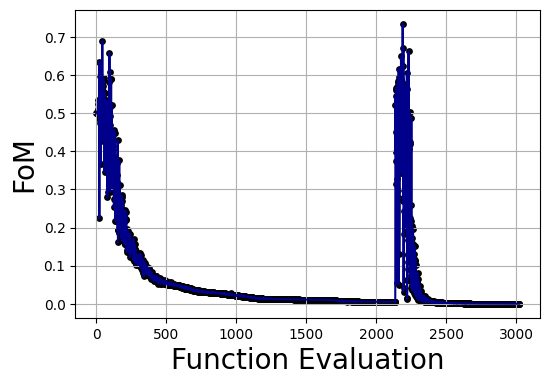

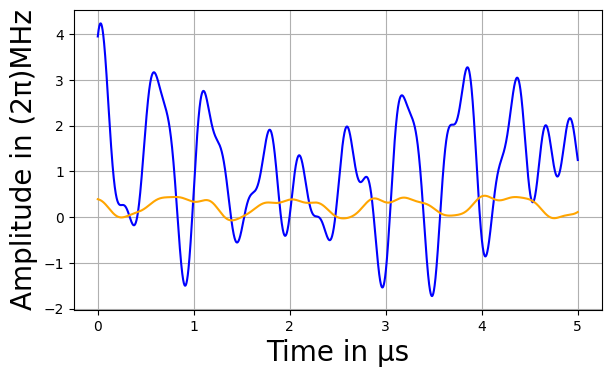

In [15]:
# Get the optimization algorithm object from the optimization object|
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary

pulse1, timegrid1 = controls["pulses"][0], controls["timegrids"][0]
pulse2, timegrid2 = controls["pulses"][1], controls["timegrids"][1]



# Plot the pulse over time
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.plot(timegrid1, pulse1/(2*np.pi), color='blue', linewidth=1.5, zorder=10)
plt.plot(timegrid2, pulse2/(2*np.pi), color='orange', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time in μs', fontsize=20)
plt.ylabel('Amplitude in (2π)MHz', fontsize=20)

### Results
Run the optimzed pulses from above and calculate the density matrix of the carbon atom, as well as the fidelity.

In [16]:
dt=0.001

def evolution(state,T): 

    N=int(T/dt+0.00000000001)

    mw_pulseX = np.array([tensor_together([Sx_transition,id2]) for _ in range(N)],dtype=np.complex128)
    mw_pulseY = np.array([-tensor_together([Sy_transition,id2]) for _ in range(N)],dtype=np.complex128)

    
    #Compute the time evolution 
    store = t_evolution([np.zeros_like(get_static_hamiltonian(0,[0],[0])) for _ in range(0,N)],
                        [pulse1*np.cos(pulse2),pulse1*np.sin(pulse2)], 
                        get_static_hamiltonian(gyroN*Bfield,[Azz],[Azx]),
                        [mw_pulseX,mw_pulseY], N, dt)
    
    U_final=functools.reduce(lambda a, b: b @ a, store)

    rho_final=U_final @ state @ U_final.T.conj()

    rho_part=partial_trace(rho_final,[3,2],[0])
    prob=1-abs(np.trace(rho_part@np.array([[0,0],[0,1]])))
    
    return [prob,rho_part,store]

    
    
pw_evo=evolution(get_initial_state(),length)
print(np.round(pw_evo[1],3) )        
print("FoM =",pw_evo[0])


[[0.   +0.j    0.001+0.001j]
 [0.001-0.001j 1.   -0.j   ]]
FoM = 1.5742380727878924e-06


Plot the evolution of the carbon and the electron spin system during the length of the QuOCS pulse. 

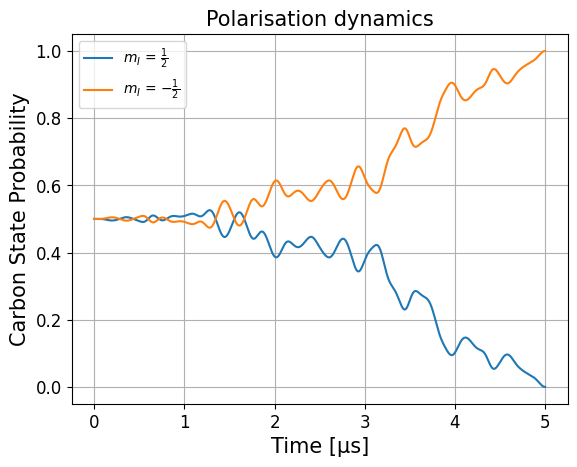

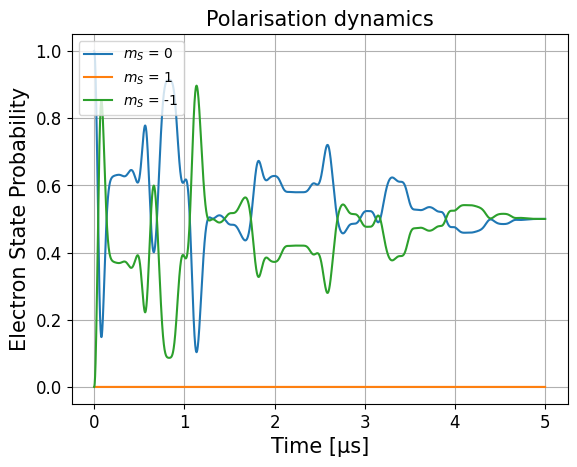

In [17]:
U_list = pw_evo[2]
U_t=[np.zeros_like(tensor_together([id3,id2])) for _ in range(step_number)]  
U_t[0]=U_list[0]
rho_t=[np.zeros_like(tensor_together([id3,id2])) for _ in range(step_number)]
rho_t[0]=get_initial_state()

for n in range(1,len(U_list)):
    U_t[n]=U_list[n]@U_t[n-1]
    rho_t[n] = U_t[n-1] @ rho_t[0] @ U_t[n-1].T.conj()

electron_evol=np.array([partial_trace(rho_t[i],[3,2],[1]) for i in range(len(rho_t))])
carbon_evol=np.array([partial_trace(rho_t[i],[3,2],[0]) for i in range(len(rho_t))])

prob_e_0=[np.abs(np.trace(elements*np.array([[0,0,0],[0,1,0],[0,0,0]]))) for elements in electron_evol]
prob_e_1=[np.abs(np.trace(elements*np.array([[1,0,0],[0,0,0],[0,0,0]]))) for elements in electron_evol]
prob_e_minus_1=[np.abs(np.trace(elements*np.array([[0,0,0],[0,0,0],[0,0,1]]))) for elements in electron_evol]

prob_c1_0=[np.abs(np.trace(elements*np.array([[1,0],[0,0]]))) for elements in carbon_evol]
prob_c1_1=[np.abs(np.trace(elements*np.array([[0,0],[0,1]]))) for elements in carbon_evol]

end=len(prob_c1_0)

plt.plot(np.arange(0,end)*dt,prob_c1_0, label=r"$m_I$ = $\frac{1}{2}$")
plt.plot(np.arange(0,end)*dt,prob_c1_1, label=r"$m_I$ = $-\frac{1}{2}$" )
plt.xlabel("Time [μs]",fontsize=15)
plt.ylabel("Carbon State Probability",fontsize=15)
plt.title("Polarisation dynamics",fontsize=15)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend(loc="upper left")
plt.grid("True")
plt.show()
plt.plot(np.arange(0,end)*dt,prob_e_0, label=r"$m_S$ = 0")
plt.plot(np.arange(0,end)*dt,prob_e_1, label=r"$m_S$ = 1" )
plt.plot(np.arange(0,end)*dt,prob_e_minus_1, label=r"$m_S$ = -1" )
plt.xlabel("Time [μs]",fontsize=15)
plt.ylabel("Electron State Probability",fontsize=15)
plt.title("Polarisation dynamics",fontsize=15)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend(loc="upper left")
plt.grid("True")

### Back to laboratory frame

The optimization within the rotating frame was achieved using the rotating wave approximation. To see the effects of this approximation, we transfrom the Hamiltonian back into the laboratory frame and apply our optimized pulse here. To achieve reasonable results within this framework, a much smaller step size is needed because the electronic spin system rotates very quickly (Lamor frequency and zero field splitting in the $GHz$ regime). The above pulses are interpolated to account for the increased steps.

In [18]:
dt_lab=0.00001  #smaller step size

def evolution(state,T):  

    N=int(T/dt_lab+0.000000001)

    timegrid=np.linspace(0,T,N)
    
    #interpolatin of the pulses
    pulseAmp=np.interp(timegrid,timegrid1,pulse1)
    pulsePhase=np.interp(timegrid,timegrid2,pulse2)

    #transition frequency between m_S=0 and m_S=-1
    mw_freq = (2870 - 2.8*Bfield) 
    

    mw_pulseX = np.array([np.cos(2*np.pi*mw_freq*timegrid[i]+pulsePhase[i])*tensor_together([Sx,id2]) for i in range(0,N)],dtype=np.complex128)
    
    
    store = t_evolution([np.zeros_like(get_lab_hamiltonian(0,0,0,[0],[0])) for _ in range(0,N)],
                        [2*pulseAmp], 
                        get_lab_hamiltonian(zeroF,Bfield*gyroE,Bfield*gyroN,[Azz],[Azx])
                        ,[mw_pulseX], N, dt_lab)
    #self.propagators_are_computed = True
    U_final = functools.reduce(lambda a, b: b @ a, store)   
    # evolve initial state
    rho_final = U_final @ state @ U_final.T.conj()

    
    rho_part=partial_trace(rho_final,[3,2],[0])
    prob=1-abs(np.trace(rho_part@np.array([[0,0],[0,1]])))
    return [prob,rho_part,store,N]


        
pw_evo_lab=evolution(get_initial_state(),length)
            
print(np.round(pw_evo_lab[1],3))           
print("FoM =",pw_evo_lab[0])


[[0.   +0.j    0.001+0.002j]
 [0.001-0.002j 1.   +0.j   ]]
FoM = 0.00034130611085858575


Plot the evolution of the carbon and the electron spin system within the lab frame during the length of the QuOCS pulse. 

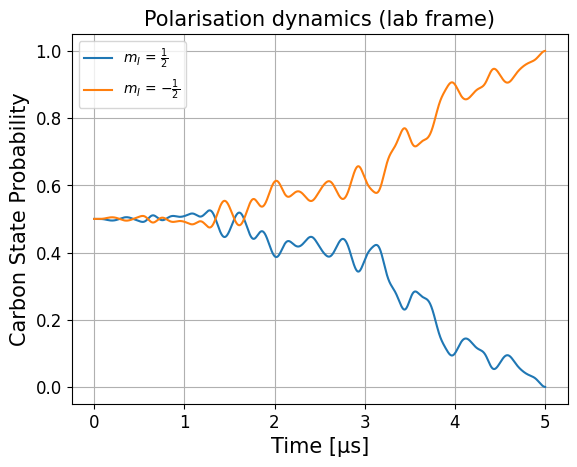

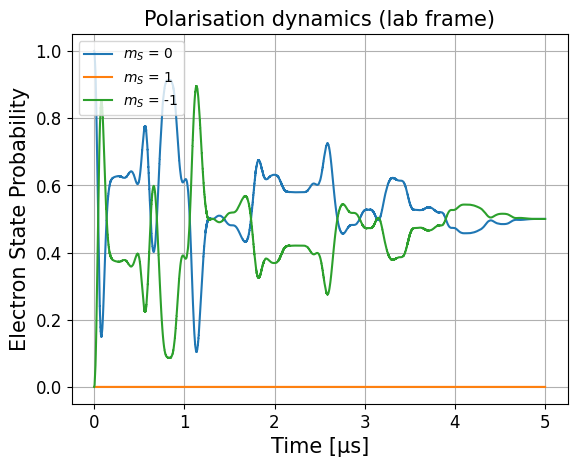

In [19]:
U_list_lab = pw_evo_lab[2]
U_t_lab=[np.zeros_like(tensor_together([id3,id2])) for _ in range(len(pw_evo_lab[2]))]  
U_t_lab[0]=U_list_lab[0]
rho_t_lab=[np.zeros_like(tensor_together([id3,id2])) for _ in range(len(pw_evo_lab[2]))]
rho_t_lab[0]=get_initial_state()

for n in range(1,len(U_list_lab)):
    U_t_lab[n]=U_list_lab[n]@U_t_lab[n-1]
    rho_t_lab[n] = U_t_lab[n-1] @ rho_t_lab[0] @ U_t_lab[n-1].T.conj()

electron_evol_lab=np.array([partial_trace(rho_t_lab[i],[3,2],[1]) for i in range(len(rho_t_lab))])
carbon_evol_lab=np.array([partial_trace(rho_t_lab[i],[3,2],[0]) for i in range(len(rho_t_lab))])

prob_e_0_lab=[np.abs(np.trace(elements*np.array([[0,0,0],[0,1,0],[0,0,0]]))) for elements in electron_evol_lab]
prob_e_1_lab=[np.abs(np.trace(elements*np.array([[1,0,0],[0,0,0],[0,0,0]]))) for elements in electron_evol_lab]
prob_e_minus_1_lab=[np.abs(np.trace(elements*np.array([[0,0,0],[0,0,0],[0,0,1]]))) for elements in electron_evol_lab]

prob_c1_0_lab=[np.abs(np.trace(elements*np.array([[1,0],[0,0]]))) for elements in carbon_evol_lab]
prob_c1_1_lab=[np.abs(np.trace(elements*np.array([[0,0],[0,1]]))) for elements in carbon_evol_lab]

end_lab=len(prob_c1_0_lab)

plt.plot(np.arange(0,end_lab)*dt_lab,prob_c1_0_lab, label=r"$m_I$ = $\frac{1}{2}$")
plt.plot(np.arange(0,end_lab)*dt_lab,prob_c1_1_lab, label=r"$m_I$ = $-\frac{1}{2}$" )
plt.xlabel("Time [μs]",fontsize=15)
plt.ylabel("Carbon State Probability",fontsize=15)
plt.title("Polarisation dynamics (lab frame)",fontsize=15)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend(loc="upper left")
plt.grid("True")
plt.show()
plt.plot(np.arange(0,end_lab)*dt_lab,prob_e_0_lab, label=r"$m_S$ = 0")
plt.plot(np.arange(0,end_lab)*dt_lab,prob_e_1_lab, label=r"$m_S$ = 1" )
plt.plot(np.arange(0,end_lab)*dt_lab,prob_e_minus_1_lab, label=r"$m_S$ = -1" )
plt.xlabel("Time [μs]",fontsize=15)
plt.ylabel("Electron State Probability",fontsize=15)
plt.title("Polarisation dynamics (lab frame)",fontsize=15)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend(loc="upper left")
plt.grid("True")

### Comparison between the rotating frame with (RWA) and the laboratory frame

The difference in state evolution between the two frames is plotted below. As can be seen, the difference is of order $10^{-3}$, showing that the RWA is a reasonable choice which greatly reduces the computational cost of our optimization.

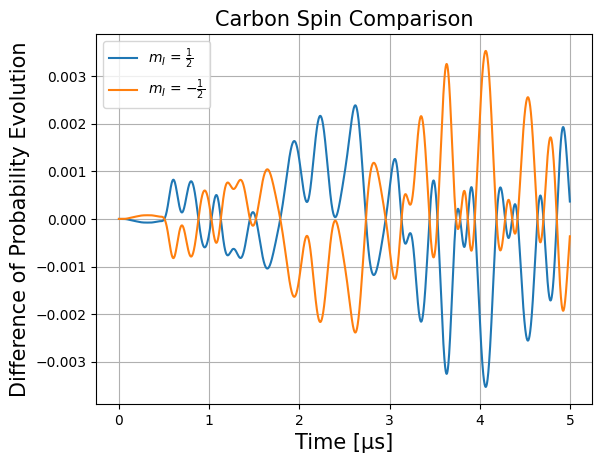

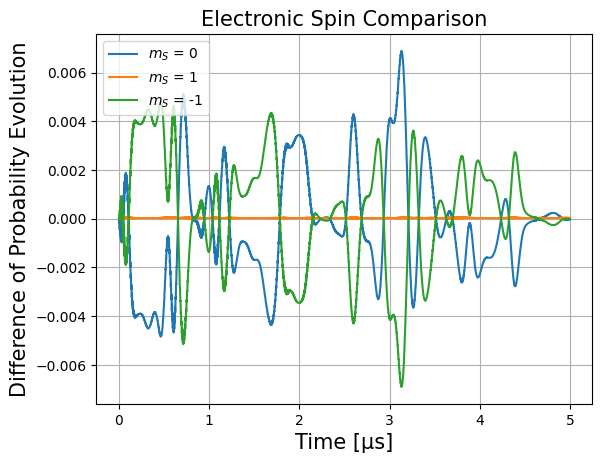

In [21]:
plt.plot(np.arange(0,end)*dt,np.array(prob_c1_0_lab[0::100])-np.array(prob_c1_0), label=r"$m_I$ = $\frac{1}{2}$")
plt.plot(np.arange(0,end)*dt,np.array(prob_c1_1_lab[0::100])-np.array(prob_c1_1), label=r"$m_I$ = $-\frac{1}{2}$")
plt.xlabel("Time [μs]",fontsize=15)
plt.ylabel("Difference of Probability Evolution",fontsize=15)
plt.title("Carbon Spin Comparison",fontsize=15)
plt.legend(loc="upper left")
plt.grid("True")
plt.show()
plt.plot(np.arange(0,end)*dt,np.array(prob_e_0_lab[0::100])-np.array(prob_e_0), label=r"$m_S$ = 0")
plt.plot(np.arange(0,end)*dt,np.array(prob_e_1_lab[0::100])-np.array(prob_e_1), label=r"$m_S$ = 1")
plt.plot(np.arange(0,end)*dt,np.array(prob_e_minus_1_lab[0::100])-np.array(prob_e_minus_1), label=r"$m_S$ = -1")
plt.xlabel("Time [μs]",fontsize=15)
plt.ylabel("Difference of Probability Evolution",fontsize=15)
plt.title("Electronic Spin Comparison",fontsize=15)
plt.legend(loc="upper left")
plt.grid("True")